In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [41]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 5
max_v = 0.5
n_train = 1 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_SHM_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[1.67965244]
[-0.03790845]


In [ ]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,0], label="q",color="red")
ax1.plot(np.linspace(0.01, 10-0.01, data[0].shape[0]),data[0][:,1], label="p",color="blue")
ax1.set_xlabel("t")
ax1.legend()
ax2.plot(data[0][:,0],data[0][:,1])
ax2.scatter(np.radians(train_starting_position), np.radians(train_starting_velocity),color="red")
#ax2.scatter(train_starting_position, train_starting_velocity,color="red")
ax2.set_xlabel("q")
ax2.set_ylabel("p")
plt.savefig("figures/pendulum_trajectory_1D.pdf")

In [43]:

eva_future_moi = []
eva_future_inv = []
moi = get_GPR_model(get_MOI(), mean, data, 500)
jitter = 1e-5
try:
    invar_density = 40
    kernel = get_SHM_invariance(5, invar_density, jitter) #switch
    m = get_GPR_model(kernel, mean, data, 500)
except tf.errors.InvalidArgumentError:
    print("jitter too small")

grids = (5, 40)
dynamics=SHM_dynamics
lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = m.log_marginal_likelihood().numpy()
grid_moi = (evaluate_model_grid(moi, grids, dynamics))
grid_inv = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)

for i in range(3):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting)
    eva_future_moi.append(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(m, test_starting, dynamics,time_setting)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])



68.13779521443999
82.7468360384751
0
0.003450216704542685
1
0.2350380733216656
2
0.0635436810168967


In [ ]:

lml_inv = np.zeros(5)
future_inv = np.zeros((3,5))
grid_inv = np.zeros(5)
dofs = np.zeros(5)
moi = get_GPR_model(get_MOI(), mean, data, 500)
lml_inv[0]=(moi.log_marginal_likelihood().numpy())
grid_inv[0]=(evaluate_model_grid(moi, grids, dynamics))
dofs[0] = degree_of_freedom(moi.kernel, np.radians(150),40,moi.likelihood.variance.numpy())
jitter=1e-5
for j, invar_density in enumerate([5, 10, 20, 40]):
    print(invar_density)
    try:
        kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
        m = get_GPR_model(kernel, mean, data, 500)
    except tf.errors.InvalidArgumentError:
        print("jitter too small")
        break 
    lml_inv[j+1]=(m.log_marginal_likelihood().numpy())
    grid_inv[j+1]=(evaluate_model_grid(m, grids, dynamics))
    dofs[j+1] = degree_of_freedom(m.kernel, np.radians(150),40,m.likelihood.variance.numpy())
    print(m.log_marginal_likelihood().numpy())
    for i in range(3):
        test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
        test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))
        test_starting = (test_starting_position, test_starting_velocity)

#        print(test_starting_position)
#        print(test_starting_velocity)

        evaluate_moi = evaluate_model_future(moi, test_starting, dynamics, time_setting)

        future_inv[i,0]=(evaluate_moi[0])

        evaluate_invariance = evaluate_model_future(m, test_starting, dynamics, time_setting)
        print(format(evaluate_invariance[0],".4f"))
        future_inv[i,j+1] = (evaluate_invariance[0])



In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2)
invs =[5, 10, 20, 40]
axs[0][0].plot(invs, lml_inv[1:5])
#axs[0][0].plot(invs, np.ones(4)*lml_inv[0],'--', color="black")
axs[0][0].set_ylabel("log marginal likelihood")
axs[0][0].set_xlabel("invariance density")
#axs[0][0].set_xscale('log')
axs[0][1].plot(invs, np.mean(future_inv[:,1:5],0))
#axs[0][1].plot(invs, np.ones(4)*np.mean(future_inv[:,0],0),'--', color="black")
axs[0][1].set_ylabel("future prediction MSE")
axs[0][1].set_xlabel("invariance density")
#axs[0][1].set_xscale('log')
axs[1][0].plot(invs, grid_inv[1:5])
#axs[1][0].plot(invs, np.ones(4)*grid_inv[0],'--', color="black")
axs[1][0].set_xlabel("invariance density")
axs[1][0].set_ylabel("restoring dynamics MSE")
#axs[1][0].set_xscale('log')
axs[1][1].plot(invs, dofs[1:5])
#axs[1][1].plot(invs, np.ones(4)*dofs[0],'--', color="black")
axs[1][1].set_ylabel("degree of freedom")
axs[1][1].set_xlabel("invariance density")
#axs[1][1].set_xscale('log')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("vary_invariance_density.pdf")

In [44]:

print("Baseline RBF & " + format((lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format((grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format((lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((grid_inv),".4f")+ ' \\\\')

Baseline RBF & 68.14 & 2.2682 & 7.5111 \\
Invariance Kernel & 82.75 & 0.1007 & 3.8778 \\


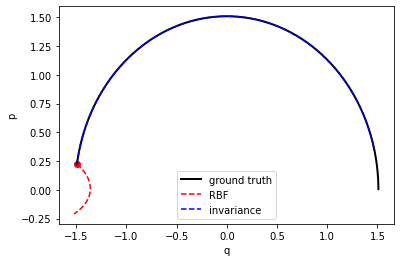

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="invariance", color="blue")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/shm_predicted_trajectory.pdf")

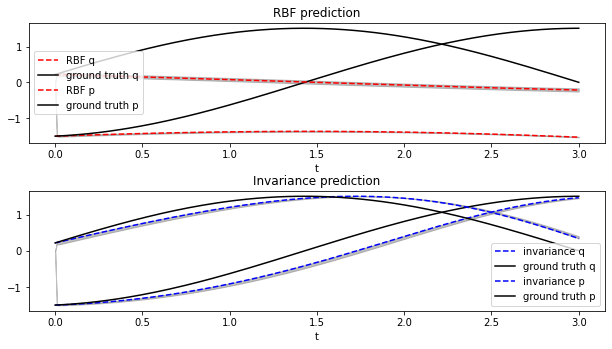

In [46]:

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,5))
t = np.linspace(0, testing_time, int(testing_time/time_step))
ax1.plot(t,evaluate_moi[1][:,0],'--',label="RBF q", color="red" )
ax1.plot(t, evaluate_moi[4][:,0], label="ground truth q", color="black")
ax1.fill_between(t,evaluate_moi[2][:,0],evaluate_moi[3][:,0], color="grey", alpha=0.5)
ax1.plot(t,evaluate_moi[1][:,1],'--',label="RBF p", color="red")
ax1.plot(t, evaluate_moi[4][:,1], label="ground truth p", color="black")
ax1.fill_between(t,evaluate_moi[2][:,1],evaluate_moi[3][:,1], color="grey", alpha=0.5)
ax1.set_xlabel("t")
ax1.set_title("RBF prediction")
ax1.legend()

ax2.plot(t,evaluate_invariance[1][:,0], '--', label="invariance q", color="blue")
ax2.plot(t, evaluate_moi[4][:,0],label="ground truth q", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,0],evaluate_invariance[3][:,0], color="grey", alpha=0.5)
ax2.plot(t,evaluate_invariance[1][:,1], '--', label="invariance p", color="blue")
ax2.plot(t, evaluate_moi[4][:,1],label="ground truth p", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,1],evaluate_invariance[3][:,1], color="grey", alpha=0.5)
ax2.set_xlabel("t")
ax2.set_title("Invariance prediction")
ax2.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/shm_predicted_trajectory_seperate.pdf")

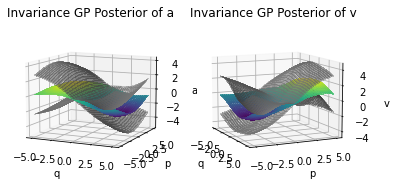

In [48]:
test_range = 5
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = m.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("Invariance GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("Invariance GP Posterior of v")
plt.savefig("figures/posterior_shm_invariance.pdf")

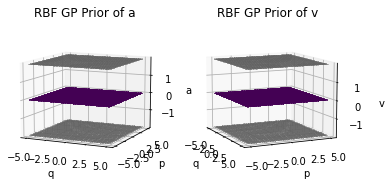

In [50]:
test_range = 5
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred = tf.zeros((test_points.shape[0], 1), dtype=tf.float64)
#var = tf.linalg.diag_part(get_pendulum_invariance(np.radians(150), invar_density, jitter)(test_points))
#var = tf.linalg.diag_part(get_SHM_invariance(5, invar_density, jitter)(test_points))
var = tf.linalg.diag_part(get_MOI()(test_points))
X, Y = data
pred_a = pred
var_a = var[:int(var.shape[0]/2)]
pred_v = pred
var_v = var[int(var.shape[0]/2):]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("RBF GP Prior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("RBF GP Prior of v")
plt.savefig("figures/prior_shm_rbf.pdf")